# ✈

# **1. Entendimento do Negócio**

- **O Indicador IPCAD (Índice Nacional de Preços ao Consumidor Amplo ao Dia)**
- **Saber a desvalorização da moeda ao dia(Perda do Poder de Compra ao Dia)**
- **Montagem da estrutura geral de preços ao dia**
- **Dados Públicos do Banco Central**
- **O objetivo é saber IPCA diário, criando um novo indicador chamado IPCAD, saber o valor que a moeda perdeu no dia.**

# ✈

# **2. Entendimento dos Dados**

- **Dados Públicos do Banco Central**
- **A base Dados é do IPCA, colunas:**
 - **Data**
 - **Valor**
- **Veja abaixo os dados ⬇**
- **Qualidade boa dos Dados**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import silhouette_score
from xgboost import XGBRegressor
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('/content/bcdata.sgs.4449.csv', sep=';')

In [40]:
df.head(10)

,data,valor,ano,valor_anual,valor_dias_uteis,valor_scaled,dias,valor_bruto
0,1992-01-01,28.50,1992,274.86,178.53,0.662699,0,28.50
1,1992-02-01,29.94,1992,274.86,178.53,0.691749,31,29.94
2,1992-03-01,22.48,1992,274.86,178.53,0.541255,60,22.48
3,1992-04-01,19.35,1992,274.86,178.53,0.478112,91,19.35
4,1992-05-01,19.88,1992,274.86,178.53,0.488804,121,19.88
5,1992-06-01,19.46,1992,274.86,178.53,0.480331,152,19.46
6,1992-07-01,24.11,1992,274.86,178.53,0.574138,182,24.11
7,1992-08-01,26.60,1992,274.86,178.53,0.624370,213,26.60
8,1992-09-01,21.26,1992,274.86,178.53,0.516643,244,21.26
9,1992-10-01,21.46,1992,274.86,178.53,0.520678,274,21.46


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    392 non-null    object
 1   valor   392 non-null    object
dtypes: object(2)
memory usage: 6.2+ KB


In [5]:
df.describe()

,data,valor
count,392,392
unique,392,225
top,01/01/1992,"0,26"
freq,1,10


In [6]:
df.dtypes

,0
data,object
valor,object


# ✈

# **3. Preparação do Dados**

- **Seleção de Colunas: ['data', 'valor']**
- **Limpeza**
- **Construção de novas colunas  ['valor_anual', 'valor_dias__uteis', 'valor_scaled']**
- **Criando o escalador com intervalo desejado (padrão é 0 a 1)**
- **Desenvolvendo melhores condiação para o DF**


In [7]:
# Remover espaços em branco e caracteres especiais, se houver
df['valor'] = df['valor'].str.replace(',', '.').str.replace(' ', '').astype(float)

In [8]:
# Verificar Valores Ausentes
df.isnull().sum()

,0
data,0
valor,0


In [9]:
# Formato adequado para análise
df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y')
print(df.dtypes)

data     datetime64[ns]
valor           float64
dtype: object


In [10]:
# Criar uma nova coluna com o ano
df['ano'] = df['data'].dt.year

# Agrupar os dados por ano e calcular a soma do IPCA (ou outra métrica)
ipca_por_ano = df.groupby('ano')['valor'].sum().reset_index()

# Renomear a coluna para 'valor_anual'
ipca_por_ano.rename(columns={'valor': 'valor_anual'}, inplace=True)

# Mesclar o DataFrame original com o DataFrame de IPCA anual
df = pd.merge(df, ipca_por_ano, on='ano', how='left')

# Exibir o resultado
print(ipca_por_ano)

     ano  valor_anual
0   1992       274.86
1   1993       388.43
2   1994       254.16
3   1995        25.33
4   1996        18.69
5   1997        17.04
6   1998         3.21
7   1999        19.23
8   2000        12.30
9   2001        10.33
10  2002        14.43
11  2003        12.55
12  2004         9.77
13  2005         8.64
14  2006         4.20
15  2007         1.64
16  2008         3.23
17  2009         4.64
18  2010         3.09
19  2011         6.04
20  2012         3.59
21  2013         1.54
22  2014         5.20
23  2015        16.77
24  2016         5.39
25  2017         7.75
26  2018         6.06
27  2019         5.42
28  2020         2.64
29  2021        15.77
30  2022        -3.72
31  2023         8.79
32  2024         3.90


In [11]:
# 5. Exibir o DataFrame atualizado com a nova coluna 'valor_anual'
print(df.head())

        data  valor   ano  valor_anual
0 1992-01-01  28.50  1992       274.86
1 1992-02-01  29.94  1992       274.86
2 1992-03-01  22.48  1992       274.86
3 1992-04-01  19.35  1992       274.86
4 1992-05-01  19.88  1992       274.86


In [12]:
#  Filtrar apenas dias úteis (dias que não são finais de semana)
df_dias_uteis = df[df['data'].dt.weekday < 5]  # Dias úteis são de 0 (segunda) a 4 (sexta)

In [13]:
# Criar uma nova coluna com o ano e agrupar por ano para calcular a soma do IPCA
df_dias_uteis['ano'] = df_dias_uteis['data'].dt.year
ipca_dias_uteis = df_dias_uteis.groupby('ano')['valor'].sum().reset_index()

# Renomear a coluna para 'valor_dias_uteis'
ipca_dias_uteis.rename(columns={'valor': 'valor_dias_uteis'}, inplace=True)

# Primeiro, criamos a coluna 'ano' em 'df' para usar na mesclagem
df['ano'] = df['data'].dt.year

# Mesclar o DataFrame original com o DataFrame de IPCA dos dias úteis
df = pd.merge(df, ipca_dias_uteis, on='ano', how='left')

# Exibir o resultado
print(ipca_dias_uteis)

     ano  valor_dias_uteis
0   1992            178.53
1   1993            323.65
2   1994            171.92
3   1995             16.57
4   1996             13.94
5   1997             12.13
6   1998              3.28
7   1999             17.00
8   2000              7.51
9   2001              6.03
10  2002             11.83
11  2003              9.42
12  2004              8.24
13  2005              6.26
14  2006              2.63
15  2007              1.33
16  2008              2.36
17  2009              3.66
18  2010              2.77
19  2011              4.09
20  2012              1.83
21  2013              0.09
22  2014              3.85
23  2015              9.63
24  2016              3.45
25  2017              5.29
26  2018              4.50
27  2019              5.14
28  2020              1.95
29  2021             12.71
30  2022             -3.04
31  2023              6.78
32  2024              3.57


<ipython-input-13-416c314f07a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dias_uteis['ano'] = df_dias_uteis['data'].dt.year


In [14]:
# 7. Exibir o DataFrame atualizado com a nova coluna 'valor_dias_uteis'
print(df.head())

        data  valor   ano  valor_anual  valor_dias_uteis
0 1992-01-01  28.50  1992       274.86            178.53
1 1992-02-01  29.94  1992       274.86            178.53
2 1992-03-01  22.48  1992       274.86            178.53
3 1992-04-01  19.35  1992       274.86            178.53
4 1992-05-01  19.88  1992       274.86            178.53


In [15]:
df.dtypes

,0
data,datetime64[ns]
valor,float64
ano,int32
valor_anual,float64
valor_dias_uteis,float64


In [16]:
# Criando o escalador com intervalo desejado (padrão é 0 a 1)
scaler = MinMaxScaler(feature_range=(0, 1))

# Ajustando e transformando os dados
df['valor_scaled'] = scaler.fit_transform(df[['valor']])

In [17]:
df.head()

,data,valor,ano,valor_anual,valor_dias_uteis,valor_scaled
0,1992-01-01,28.50,1992,274.86,178.53,0.662699
1,1992-02-01,29.94,1992,274.86,178.53,0.691749
2,1992-03-01,22.48,1992,274.86,178.53,0.541255
3,1992-04-01,19.35,1992,274.86,178.53,0.478112
4,1992-05-01,19.88,1992,274.86,178.53,0.488804


In [18]:
df.tail()

,data,valor,ano,valor_anual,valor_dias_uteis,valor_scaled
387,2024-04-01,0.74,2024,3.9,3.57,0.102683
388,2024-05-01,0.55,2024,3.9,3.57,0.098850
389,2024-06-01,0.33,2024,3.9,3.57,0.094412
390,2024-07-01,1.08,2024,3.9,3.57,0.109542
391,2024-08-01,-0.12,2024,3.9,3.57,0.085334


# ✈

# **4. Modelagem**

- **Regressão Linear VS XGBoost**
- **Utilizo a Regressão para filtrar resultado e o XGBoost para aumentar a acurácia destes resultados, comparando os dois.**
- **Arte X Ciência**
- **Quero saber o valor do IPCA diário**

# **Preparação de Dados: Regressão Linear x XGBoost**

In [19]:
# Supondo que df seja seu DataFrame com 'data'
df['data'] = pd.to_datetime(df['data'])
df['dias'] = (df['data'] - df['data'].min()).dt.days  # Criação de variável para os dias

In [20]:
# Criar as divisões
# Parte 1: 1992 - 2002
df1 = df[(df['data'] >= '1992-01-01') & (df['data'] <= '2002-12-31')]

# Parte 2: 2003 - 2013
df2 = df[(df['data'] >= '2003-01-01') & (df['data'] <= '2013-12-31')]

# Parte 3: 2014 - 2024
df3 = df[(df['data'] >= '2014-01-01') & (df['data'] <= '2024-08-31')]

In [21]:
# Converter a coluna de data para datetime, se necessário
df1['data'] = pd.to_datetime(df1['data'], format='%Y-%m-%d')

df2['data'] = pd.to_datetime(df2['data'], format='%Y-%m-%d')

df3['data'] = pd.to_datetime(df3['data'], format='%Y-%m-%d')

<ipython-input-21-cd37cbc9d9c9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['data'] = pd.to_datetime(df1['data'], format='%Y-%m-%d')
<ipython-input-21-cd37cbc9d9c9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['data'] = pd.to_datetime(df2['data'], format='%Y-%m-%d')
<ipython-input-21-cd37cbc9d9c9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [22]:
df1.head()

,data,valor,ano,valor_anual,valor_dias_uteis,valor_scaled,dias
0,1992-01-01,28.50,1992,274.86,178.53,0.662699,0
1,1992-02-01,29.94,1992,274.86,178.53,0.691749,31
2,1992-03-01,22.48,1992,274.86,178.53,0.541255,60
3,1992-04-01,19.35,1992,274.86,178.53,0.478112,91
4,1992-05-01,19.88,1992,274.86,178.53,0.488804,121


In [23]:
df2.head()

,data,valor,ano,valor_anual,valor_dias_uteis,valor_scaled,dias
132,2003-01-01,3.83,2003,12.55,9.42,0.165019,4018
133,2003-02-01,2.71,2003,12.55,9.42,0.142425,4049
134,2003-03-01,1.08,2003,12.55,9.42,0.109542,4077
135,2003-04-01,1.21,2003,12.55,9.42,0.112165,4108
136,2003-05-01,0.81,2003,12.55,9.42,0.104095,4138


In [24]:
df3.head()

,data,valor,ano,valor_anual,valor_dias_uteis,valor_scaled,dias
264,2014-01-01,0.38,2014,5.2,3.85,0.095421,8036
265,2014-02-01,0.40,2014,5.2,3.85,0.095824,8067
266,2014-03-01,-0.02,2014,5.2,3.85,0.087351,8095
267,2014-04-01,0.77,2014,5.2,3.85,0.103288,8126
268,2014-05-01,0.59,2014,5.2,3.85,0.099657,8156


# **Regressão Linear**

In [25]:
# Função para transformar a coluna de data em anos
def get_years(df, column='data'):
    return df[column].apply(lambda x: x.year).values.reshape(-1, 1)

In [26]:
# Função para treinar o modelo e plotar os resultados
def train_and_plot(df, part_name):
    X = get_years(df)  # Pegando o ano como variável independente
    y = df['valor_scaled'].values  # Variável dependente (target)

    # Inicializar e treinar o modelo de Regressão Linear
    model = LinearRegression()
    model.fit(X, y)

    # Predizer os valores
    y_pred = model.predict(X)

    # Avaliar o modelo
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"MSE: {mse}")
    print(f"R²: {r2}")

    # Visualizar os resultados
    plt.figure(figsize=(8, 5))
    plt.scatter(X, y, color='blue', label='Dados reais')
    plt.plot(X, y_pred, color='red', label='Regressão Linear')
    plt.title(f'Regressão Linear - {part_name}')
    plt.xlabel('Ano')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()

    # Retornar o modelo treinado
    return model

Treinando o modelo para a Parte 1 (1992 - 2002)
MSE: 0.03795223169264894
R²: 0.43927151208144943


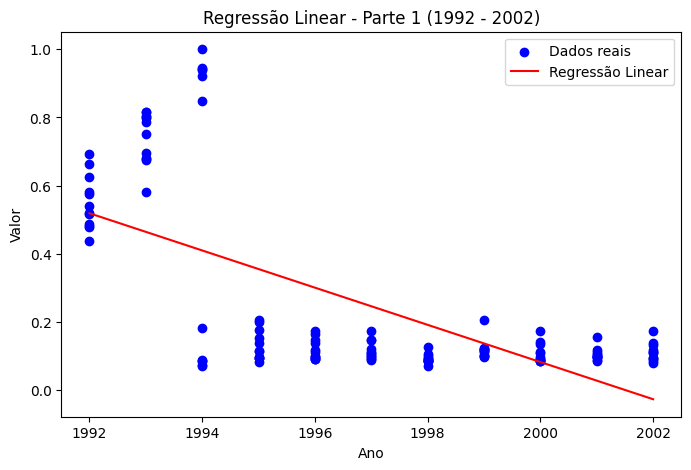

Treinando o modelo para a Parte 2 (2003 - 2013)
MSE: 0.00010883476926377667
R²: 0.139158354472797


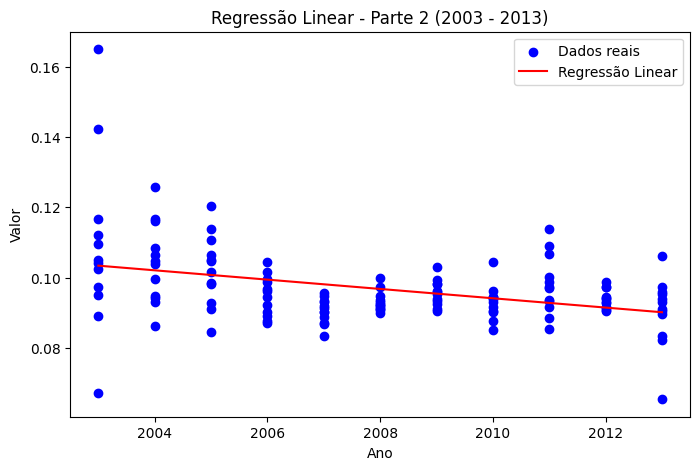

Treinando o modelo para a Parte 3 (2014 - 2024)
MSE: 0.0003824959435136737
R²: 0.011667776462210955


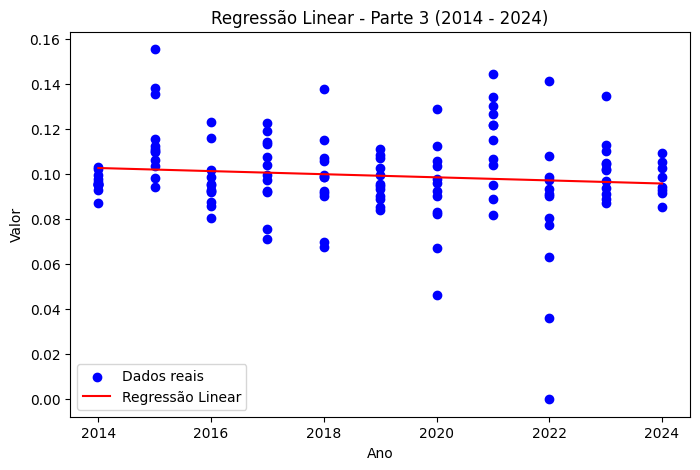

In [27]:
# Parte 1: Treinando e plotando
print("Treinando o modelo para a Parte 1 (1992 - 2002)")
model1 = train_and_plot(df1, 'Parte 1 (1992 - 2002)')

# Parte 2: Treinando e plotando
print("Treinando o modelo para a Parte 2 (2003 - 2013)")
model2 = train_and_plot(df2, 'Parte 2 (2003 - 2013)')

# Parte 3: Treinando e plotando
print("Treinando o modelo para a Parte 3 (2014 - 2024)")
model3 = train_and_plot(df3, 'Parte 3 (2014 - 2024)')

# **XGBoost**

In [28]:
# Função para treinar o modelo XGBoost e plotar os resultados
def train_and_plot_xgboost(df, part_name):
    X = get_years(df)  # Pegando o ano como variável independente
    y = df['valor_scaled'].values  # Variável dependente (target)

    # Ajustar Hiperpârametros
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, objective='reg:squarederror')

    # Inicializar e treinar o modelo de XGBoost
    model = xgb.XGBRegressor(objective ='reg:squarederror')
    model.fit(X, y)

    # Predizer os valores
    y_pred = model.predict(X)

    # Avaliando o desempenho do XGBoost
    mse_xgb = mean_squared_error(y, y_pred)
    r2_xgb = r2_score(y, y_pred)
    print(f"MSE: {mse_xgb}")
    print(f"R²: {r2_xgb}")

    # Visualizar os resultados
    plt.figure(figsize=(8, 5))
    plt.scatter(X, y, color='blue', label='Dados reais')
    plt.plot(X, y_pred, color='red', label='XGBoost Regressor')
    plt.title(f'XGBoost - {part_name}')
    plt.xlabel('Ano')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()

    # Retornar o modelo treinado
    return model


Treinando o modelo XGBoost para a Parte 1 (1992 - 2002)
MSE: 0.01753214725143976
R²: 0.7409697933476376


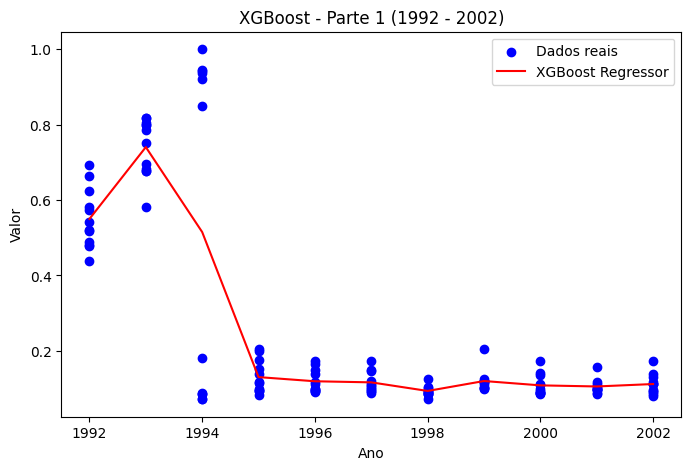

Treinando o modelo XGBoost para a Parte 2 (2003 - 2013)
MSE: 9.423377633374901e-05
R²: 0.25464665720216595


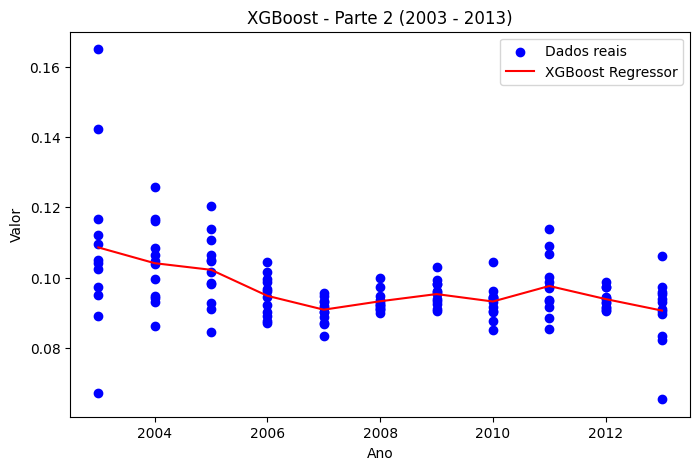

Treinando o modelo XGBoost para a Parte 3 (2014 - 2024)
MSE: 0.00030226242039454977
R²: 0.21898337719291416


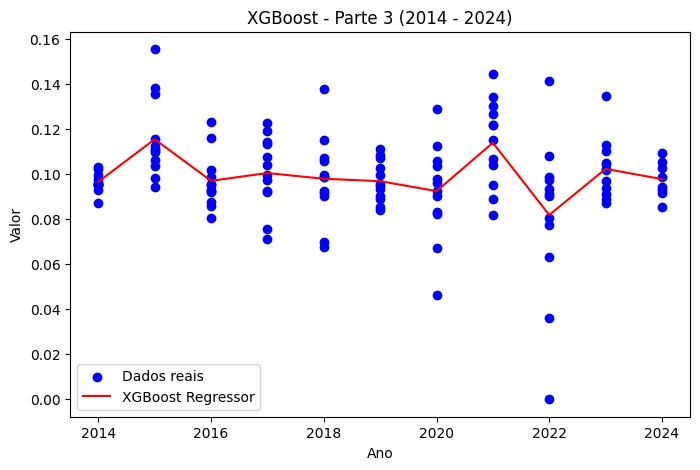

In [29]:
# Parte 1: Treinando e plotando
print("Treinando o modelo XGBoost para a Parte 1 (1992 - 2002)")
model1_xgb = train_and_plot_xgboost(df1, 'Parte 1 (1992 - 2002)')

# Parte 2: Treinando e plotando
print("Treinando o modelo XGBoost para a Parte 2 (2003 - 2013)")
model2_xgb = train_and_plot_xgboost(df2, 'Parte 2 (2003 - 2013)')

# Parte 3: Treinando e plotando
print("Treinando o modelo XGBoost para a Parte 3 (2014 - 2024)")
model3_xgb = train_and_plot_xgboost(df3, 'Parte 3 (2014 - 2024)')

# **Calculo do Linkage**

In [30]:
# Função para calcular o Linkage e plotar o dendrograma
def calculate_linkage(df, part_name):
    # Preparar os dados (neste caso, usamos o valor como base para o Linkage)
    X = df[['valor_scaled']].values

    # Calcular o Linkage (pode ajustar o método: 'single', 'complete', 'average', etc.)
    Z = linkage(X, method='ward')  # 'ward' é comum, minimiza a variância dentro dos clusters

    # Plotar o dendrograma
    plt.figure(figsize=(8, 5))
    dendrogram(Z)
    plt.title(f'Dendrograma - {part_name}')
    plt.xlabel('Index dos Dados')
    plt.ylabel('Distância')
    plt.show()

Calculando o Linkage para a Parte 1 (1992 - 2002)


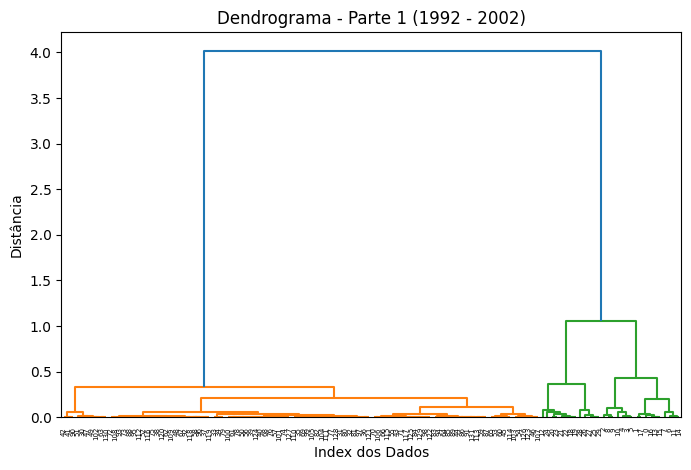

Calculando o Linkage para a Parte 2 (2003 - 2013)


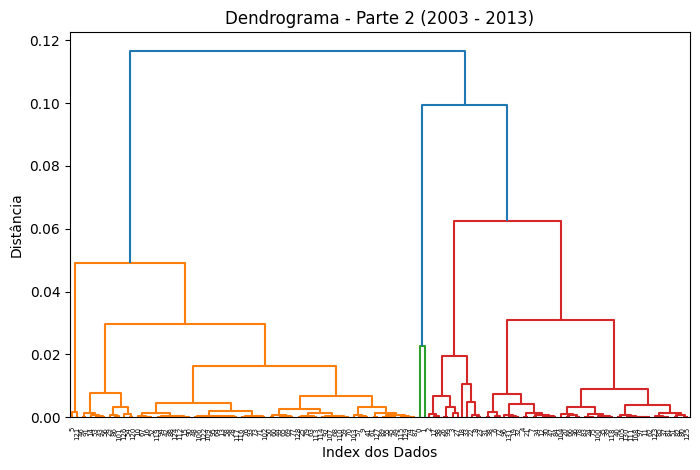

Calculando o Linkage para a Parte 3 (2014 - 2024)


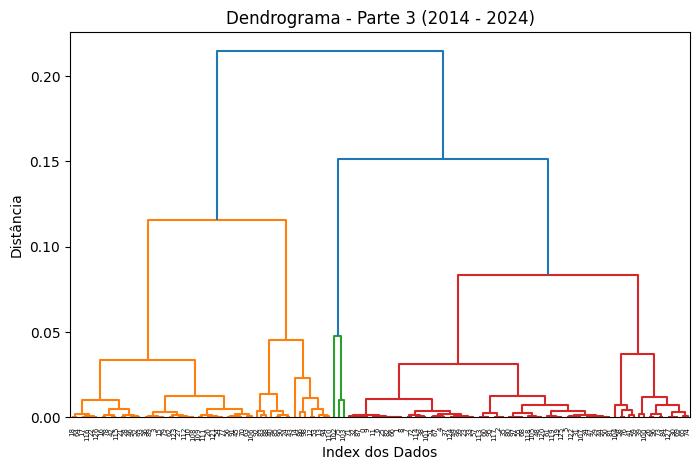

In [31]:
# Parte 1: Linkage e Dendrograma
print("Calculando o Linkage para a Parte 1 (1992 - 2002)")
calculate_linkage(df1, 'Parte 1 (1992 - 2002)')

# Parte 2: Linkage e Dendrograma
print("Calculando o Linkage para a Parte 2 (2003 - 2013)")
calculate_linkage(df2, 'Parte 2 (2003 - 2013)')

# Parte 3: Linkage e Dendrograma
print("Calculando o Linkage para a Parte 3 (2014 - 2024)")
calculate_linkage(df3, 'Parte 3 (2014 - 2024)')

In [32]:
# Adicionando uma coluna de ano a cada parte
df1['ano'] = df1['data'].dt.year
df2['ano'] = df2['data'].dt.year
df3['ano'] = df3['data'].dt.year

<ipython-input-32-c7ed47e8b752>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['ano'] = df1['data'].dt.year
<ipython-input-32-c7ed47e8b752>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ano'] = df2['data'].dt.year
<ipython-input-32-c7ed47e8b752>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

# **Dados Categorizados e Visualizações**

<ipython-input-33-21b2fb1ceb90>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_data, x='ano', y='valor_scaled', palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping 

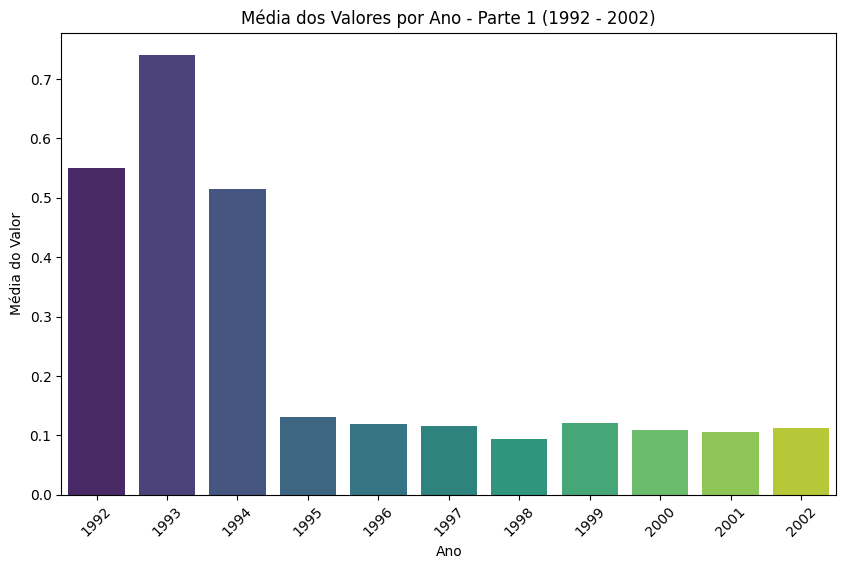

<ipython-input-33-21b2fb1ceb90>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_data, x='ano', y='valor_scaled', palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping 

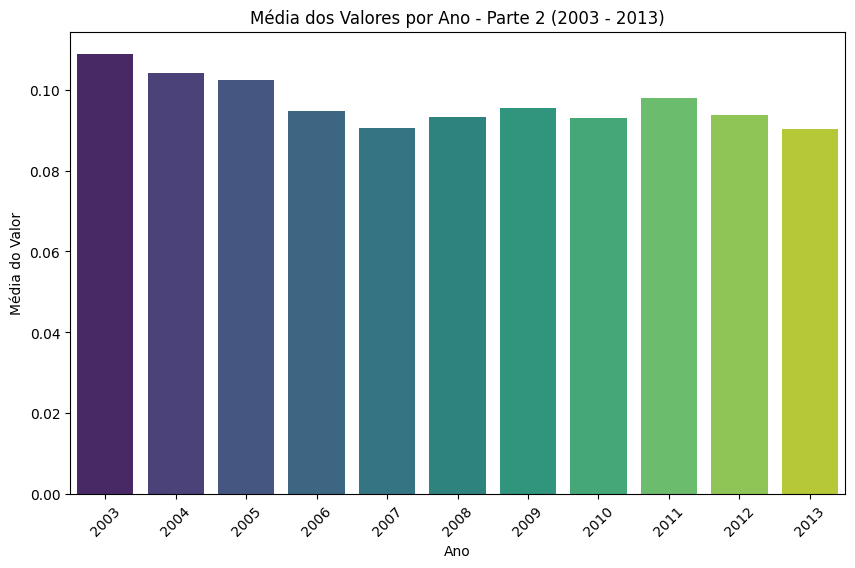

<ipython-input-33-21b2fb1ceb90>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_data, x='ano', y='valor_scaled', palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping 

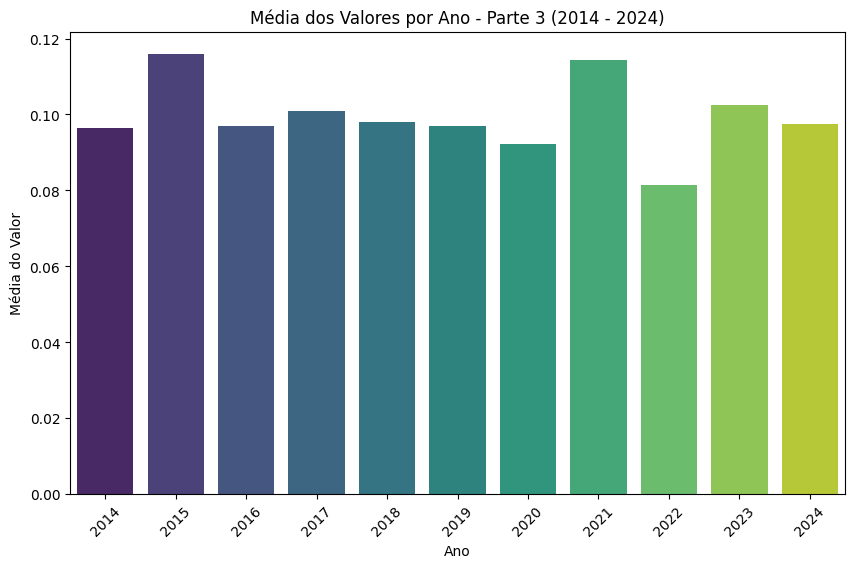

In [33]:
# Função para criar gráficos de barras
def plot_bar_chart(df, part_name):
    # Agrupar os dados por ano e calcular a média dos valores
    grouped_data = df.groupby('ano')['valor_scaled'].mean().reset_index()

    plt.figure(figsize=(10, 6))
    sns.barplot(data=grouped_data, x='ano', y='valor_scaled', palette='viridis')
    plt.title(f'Média dos Valores por Ano - {part_name}')
    plt.xlabel('Ano')
    plt.ylabel('Média do Valor')
    plt.xticks(rotation=45)
    plt.show()

# Gráfico para cada parte
plot_bar_chart(df1, 'Parte 1 (1992 - 2002)')
plot_bar_chart(df2, 'Parte 2 (2003 - 2013)')
plot_bar_chart(df3, 'Parte 3 (2014 - 2024)')

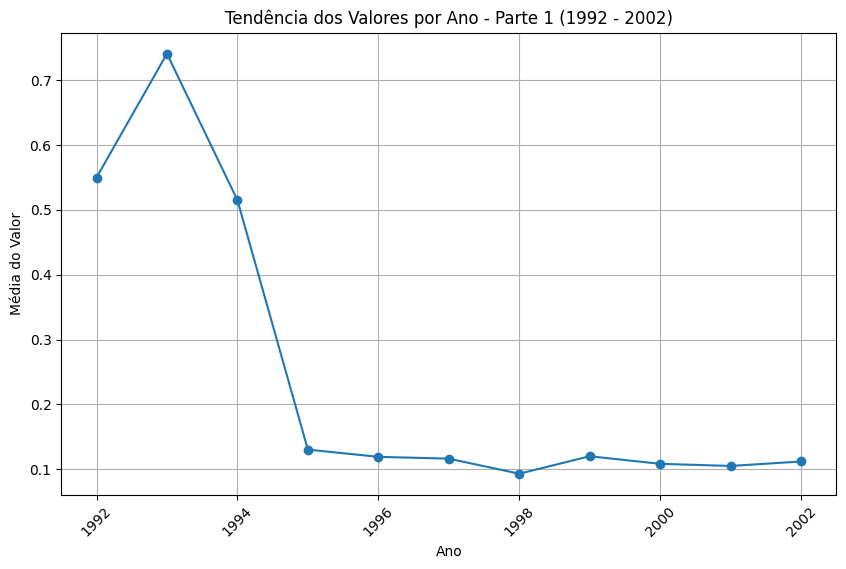

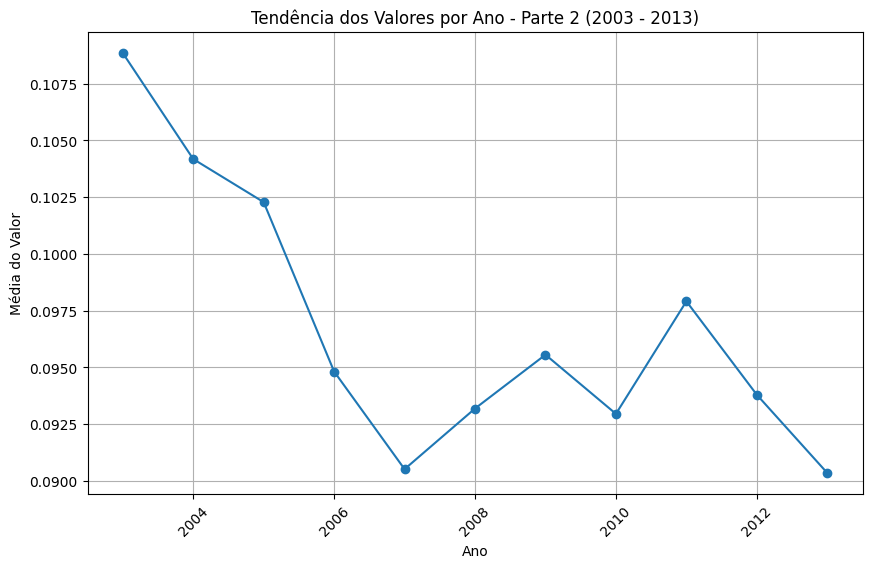

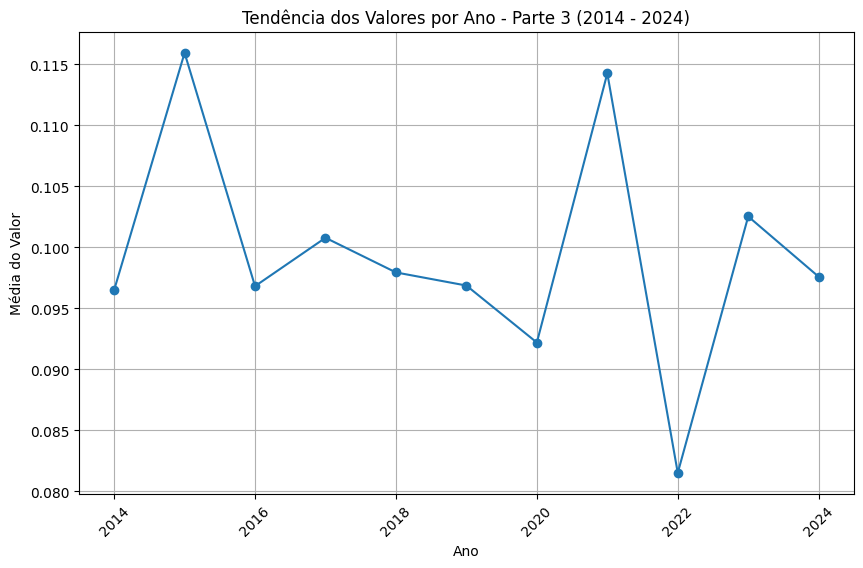

In [34]:
# Função para criar gráficos de linha
def plot_line_chart(df, part_name):
    # Agrupar os dados por ano e calcular a média dos valores
    grouped_data = df.groupby('ano')['valor_scaled'].mean().reset_index()

    plt.figure(figsize=(10, 6))
    plt.plot(grouped_data['ano'], grouped_data['valor_scaled'], marker='o')
    plt.title(f'Tendência dos Valores por Ano - {part_name}')
    plt.xlabel('Ano')
    plt.ylabel('Média do Valor')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

# Gráfico para cada parte
plot_line_chart(df1, 'Parte 1 (1992 - 2002)')
plot_line_chart(df2, 'Parte 2 (2003 - 2013)')
plot_line_chart(df3, 'Parte 3 (2014 - 2024)')

In [35]:
# Converta colunas categóricas em um tipo numérico antes de preencher valores NaN
for col in df1.select_dtypes(include='category'):
    df1[col] = df1[col].cat.codes

# Agora você pode preencher valores NaN com 0
df1.fillna(0, inplace=True)

# Repita o processo para df2 e df3
for col in df2.select_dtypes(include='category'):
    df2[col] = df2[col].cat.codes

df2.fillna(0, inplace=True)

for col in df3.select_dtypes(include='category'):
    df3[col] = df3[col].cat.codes

df3.fillna(0, inplace=True)

<ipython-input-35-4d21eec9ca8b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.fillna(0, inplace=True)
<ipython-input-35-4d21eec9ca8b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.fillna(0, inplace=True)
<ipython-input-35-4d21eec9ca8b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.fillna(0, inplace=True)


In [36]:
# Certifique-se de que a coluna 'data' está no formato datetime
df1['data'] = pd.to_datetime(df1['data'])
df2['data'] = pd.to_datetime(df2['data'])
df3['data'] = pd.to_datetime(df3['data'])

<ipython-input-36-04bb2a9b5fa5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['data'] = pd.to_datetime(df1['data'])
<ipython-input-36-04bb2a9b5fa5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['data'] = pd.to_datetime(df2['data'])
<ipython-input-36-04bb2a9b5fa5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [37]:
# Escalar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
df['valor_scaled'] = scaler.fit_transform(df[['valor']])

# Reverter a escala para os valores originais
df['valor_bruto'] = scaler.inverse_transform(df[['valor_scaled']])

print(df)

          data  valor   ano  valor_anual  valor_dias_uteis  valor_scaled  \
0   1992-01-01  28.50  1992       274.86            178.53      0.662699   
1   1992-02-01  29.94  1992       274.86            178.53      0.691749   
2   1992-03-01  22.48  1992       274.86            178.53      0.541255   
3   1992-04-01  19.35  1992       274.86            178.53      0.478112   
4   1992-05-01  19.88  1992       274.86            178.53      0.488804   
..         ...    ...   ...          ...               ...           ...   
387 2024-04-01   0.74  2024         3.90              3.57      0.102683   
388 2024-05-01   0.55  2024         3.90              3.57      0.098850   
389 2024-06-01   0.33  2024         3.90              3.57      0.094412   
390 2024-07-01   1.08  2024         3.90              3.57      0.109542   
391 2024-08-01  -0.12  2024         3.90              3.57      0.085334   

      dias  valor_bruto  
0        0        28.50  
1       31        29.94  
2       6

In [38]:
df.dtypes

,0
data,datetime64[ns]
valor,float64
ano,int32
valor_anual,float64
valor_dias_uteis,float64
valor_scaled,float64
dias,int64
valor_bruto,float64


In [39]:
# Função para calcular valores diários a partir de valores mensais
def get_daily_values_from_monthly(df):
    # Crie um novo DataFrame para valores diários
    daily_values = []

    for index, row in df.iterrows():
        # Obtenha mês e ano a partir da data
        month = row['data'].month
        year = row['data'].year

        # Obtenha mês e ano a partir dos dados
        if year is not None and month is not None:
            # Crie uma série de datas para todos os dias do mês
            num_days = 30  # ou você pode calcular o número real de dias no mês
            daily_value = row['valor_bruto'] / num_days

            for day in range(1, num_days + 1):
                daily_values.append({'data': pd.Period(year=year, month=month, freq='D').days_in_month, 'valor_bruto': daily_value})

    # Crie DataFrame com valores diários
    return pd.DataFrame(daily_values)

# Aplicar dimensionamento e transformação inversa a df1, df2 e df3
for df_temp in [df1, df2, df3]:
    # Escalar os dados
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_temp['valor_scaled'] = scaler.fit_transform(df_temp[['valor']]) # Escale a coluna 'valor' e crie 'valor_scaled'

    # Reverter a escala para os valores originais
    df_temp['valor_bruto'] = scaler.inverse_transform(df_temp[['valor_scaled']]) # Transformada inversa para criar 'valor_bruto'

# Calcular valores diários para cada peça
daily_values_1 = get_daily_values_from_monthly(df1)
daily_values_2 = get_daily_values_from_monthly(df2)
daily_values_3 = get_daily_values_from_monthly(df3)

# Exibir os resultados
print("Valores Diários - Parte 1 (1992 - 2002):")
print(daily_values_1.head())

print("\nValores Diários - Parte 2 (2003 - 2013):")
print(daily_values_2.head())

print("\nValores Diários - Parte 3 (2014 - 2024):")
print(daily_values_3.head())

<ipython-input-39-b65f86de1557>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['valor_scaled'] = scaler.fit_transform(df_temp[['valor']]) # Escale a coluna 'valor' e crie 'valor_scaled'
<ipython-input-39-b65f86de1557>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['valor_bruto'] = scaler.inverse_transform(df_temp[['valor_scaled']]) # Transformada inversa para criar 'valor_bruto'
<ipython-input-39-b65f86de1557>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Valores Diários - Parte 1 (1992 - 2002):
   data  valor_bruto
0    31         0.95
1    31         0.95
2    31         0.95
3    31         0.95
4    31         0.95

Valores Diários - Parte 2 (2003 - 2013):
   data  valor_bruto
0    31     0.127667
1    31     0.127667
2    31     0.127667
3    31     0.127667
4    31     0.127667

Valores Diários - Parte 3 (2014 - 2024):
   data  valor_bruto
0    31     0.012667
1    31     0.012667
2    31     0.012667
3    31     0.012667
4    31     0.012667


# ✈

# **5. Avaliação dos Resultados**

- **Resolve prevendo a diferencia do preço ao Dia**
- **Retorno conseguir investir, comprar, prestar serviço com a certeza que ganhou acima da inflação do periodo.**

### ▶  **O período é de 32 anos, dividi em 3 partes!**

- **Parte 1 (1992 - 2002): 0.95 ao dia**
- **Parte 2 (2003 - 2013): 0.12 ao dia**
- **Parte 3 (2014 - 2024): 0.01 ao dia**

⚾ **Chegando assim ao valor diário por período!**

⚾ **Novo Indicador IPCAD Criado!**

▶  **Dados adicionais:**

### **Valor Anual X Dias Uteis:**

- **Parte 1 (01/1992): 276.86 ano**  / **Parte 1 (1992): 178.53 dias uteis**
- **Parte 2 (01/2003): 12.55 ano**   / **Parte 2 (2003): 9.42 dias uteis**
- **Parte 3 (01/2014): 5.2 ano**     / **Parte 3 (2014): 3.85 dias uteis**

# ✈

# **6. Implantação**

- **Pode ser implementado na Montagem da Estrutura Geral de Preços ao Dia**
- **Monitoramento é diario**
- **StoryTelliny**
- **Revisão mensal**

# **Exploração e Arquitetura do CRISP-DM no Banco Central**
## Este notebook faz parte do Módulo 36 da EBAC

# **Dados:**
## Os dados representam informação do IPCA do Brasil, contam com as seguintes colunas:
- **Data**
- **valor**

# **Exploração de Dados:**
## A primeira fase da análise é entender o que tem na materia prima. Vamos explorar os dados:

**Qual a quantidade de informação temos na base de dados?**

### df = pd.read_csv('bcdata.sgs.4449.csv')
◼ Resposta: 392 linhas

**ps:** A base de dados acima contém 392 linhas e 2 colunas, para este projeto foi utilazado somente 2 colunas no método CRISP-DM.

**Como são os dados?**

/content/dados.png

**Quais tipos de cada dado?**

/content/tipos de dados.png

Agora que já entedemos quais são os tipos de dados, vamos olhar mais atentamente para as variáveis que não são numericas.

**Quais são as 3 partes no dataset?**

/content/3 partes.png

**Qual é finalidade do Método CRISP-DM?**

/content/Método CRISP-DM_img.png

O CRISP-DM metodologia ágil para o planejamento de projetos de análise, mineração e Machine Learning de dados.


# **Analise de Dados**
Analisei as 3 partes e vi uma discrepância no valor do IPCA.

**Qual das 3 partes tem menor IPCA?**

/content/Menor parte.png

**Qual das 3 partes tem maior IPCA?**

/content/Maior parte.png


**Qual é o IPCA diário?**

/content/Valores diários.png


# **Conclusão**
### **O período é de 32 anos, dividi em 3 partes!**

- **Parte 1 (1992 - 2002): 0.95 ao dia**
- **Parte 2 (2003 - 2013): 0.12 ao dia**
- **Parte 3 (2014 - 2024): 0.01 ao dia**

⚾ **Chegando assim ao valor diário por período!**

⚾ **Novo Indicador IPCAD Criado!**

##  **Dados adicionais:**

### **Valor Anual X Dias Uteis:**

- **Parte 1 (01/1992): 276.86 ano**  / **Parte 1 (1992): 178.53 dias uteis**
- **Parte 2 (01/2003): 12.55 ano**   / **Parte 2 (2003): 9.42 dias uteis**
- **Parte 3 (01/2014): 5.2 ano**     / **Parte 3 (2014): 3.85 dias uteis**

